# Monitoring changes in related words over time.

### This notebook will show how words related to a particular word will change over time deltas

In [2]:
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from math import ceil
import string
from itertools import combinations
import networkx as nx
import re

In [3]:
columns = ['tweet_id','timestamp','tweet_text','user_id',
           'tweet_coords','tweet_coords_list','tweet_long','tweet_lat','location',
           'enc_url','tweet_lang','hashtags']
tweet_full = pd.read_csv(r'./tweetCoords.csv',
                         header=None,
                         names=columns,
                         parse_dates=[1],
                         infer_datetime_format=True,
                         index_col='timestamp')

Creating a separate dataframe for just the tweets classified as english.

In [4]:
tweet_full_en = tweet_full[tweet_full['tweet_lang'] == 'en']

writing a custom text cleaner. Currently configured to remove all punctuation, _except #_.

In [5]:
tweet_stops = stopwords.words('english')
tweet_tokenizer = TweetTokenizer(strip_handles=True,preserve_case=False,reduce_len=True)

def clean_tweet(tweet):
#     takes input string and converts or removes characters depending on settings.
#     returns a string
#     convert case:
    tweet = tweet.lower()
#     remove URLs:
    tweet = re.sub('https?://\S+','',tweet)
#     remove @mentions, including those with a leading '-' or '.' : 
    tweet = re.sub('[-\.]?@\w+','',tweet)
#     remove punctuation, but not hashtags:
    tweet = tweet.translate(tweet.maketrans('','',string.punctuation.replace("#","")))
#     remove non-hashtag '#'.
    tweet = re.sub('#\B','',tweet)
#     remove 'amp', 'gt', 'lt', indicating decoded ampersand, greater-than, less-than characters
    tweet = re.sub(r'\b(amp|gt|lt)\b','',tweet)
#     remove punctuation, including hashtags:
#     tweet = tweet.translate(tweet.maketrans('','',string.punctuation))
    return tweet

def tokens_no_stopwords(tweet_as_string):
#     wrapper function that combines the tokenizer, cleaner, and stopword removal.
#     takes a string and returns a list of strings
    cleaned_tweet = clean_tweet(tweet_as_string)
    tweet_as_tokens = tweet_tokenizer.tokenize(cleaned_tweet)
    tweet_no_stops = [word for word in tweet_as_tokens if word not in tweet_stops]
    
    return tweet_no_stops
    

In [6]:
re_text = "this is ! A TWEETlt withgtamp @some .@random amp gt lt @@extra #stuff ##in IT!?@>#! "
print(tokens_no_stopwords(re_text))

['tweetlt', 'withgtamp', '#stuff', '#in']


What's the word we're comparing similarity to?

In [7]:
search_term = "irma"

Starting here, begin the iteration over times.

In [8]:
related_words = pd.DataFrame()
tweet_date = pd.to_datetime("2017-09-10 00:00:00")
date_delta = pd.Timedelta("24HR")
end_date = pd.to_datetime("2017-09-10 00:00:00")

In [9]:
top_num_words = 20 # number of words to include in cosine similarity ordered list
pct_occ_thresh = .01 # words must occur a number of times >= this percent of number of tweets.

List of words from this time frame, based upon the occurrence threshold above:

In [10]:
tweet_window = tweet_full_en.loc[tweet_date:tweet_date+date_delta]
num_tweets = len(tweet_window)
min_count = ceil(num_tweets * pct_occ_thresh)
tweet_words = tweet_window['tweet_text'].apply(tokens_no_stopwords)
word_counts = tweet_words.apply(pd.Series).stack().value_counts()

histogram of word counts. Vertical line represents 1% threshold of word count.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

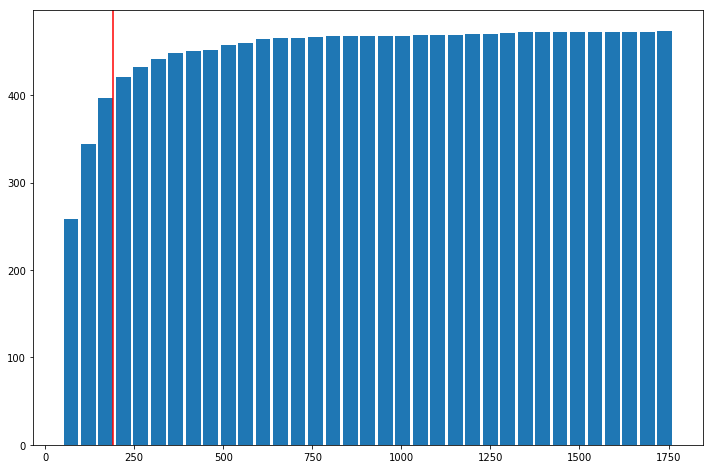

In [90]:
hist_fig = plt.figure(figsize=(12,8))

plt.hist(word_counts[word_counts > min_count/4], bins=35,cumulative=True,rwidth=.85);
plt.axvline(min_count,color='r');

In [328]:
word_counts[word_counts > min_count]

florida           1764
#hurricaneirma    1633
irma              1343
hurricane         1294
#irma             1199
fl                1072
reports            809
storm              742
power              679
mph                659
rain               632
like               628
wind               628
safe               619
gust               552
asos               544
get                539
beach              532
miami              531
knots              509
county             493
still              492
go                 466
f                  436
good               423
stay               414
us                 389
love               369
got                362
going              361
                  ... 
lol                237
2                  237
weather            236
need               233
fort               233
humidity           233
last               226
really             226
home               225
st                 225
live               215
#hurrcaneirma      212
#miami     

Stats on tokenized tweets. Starting with histogram of tweet length by word count, after processing into tokens.

In [91]:
tweet_window['tweet_text'].head(20).apply(tokens_no_stopwords).apply(len)

timestamp
2017-09-10 00:00:01    15
2017-09-10 00:00:03     7
2017-09-10 00:00:03     9
2017-09-10 00:00:06     6
2017-09-10 00:00:08     4
2017-09-10 00:00:10     6
2017-09-10 00:00:11    20
2017-09-10 00:00:11    11
2017-09-10 00:00:12     9
2017-09-10 00:00:14     3
2017-09-10 00:00:14    14
2017-09-10 00:00:16     2
2017-09-10 00:00:24     2
2017-09-10 00:00:24     9
2017-09-10 00:00:24     5
2017-09-10 00:00:37     1
2017-09-10 00:00:38     2
2017-09-10 00:00:46     3
2017-09-10 00:00:48     7
2017-09-10 00:00:50    11
Name: tweet_text, dtype: int64

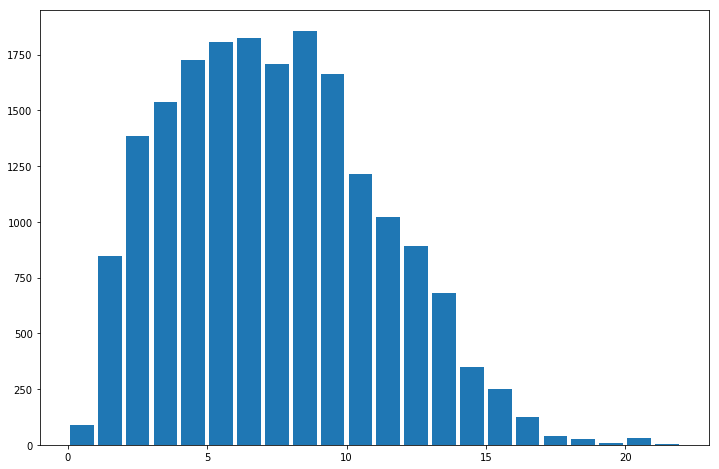

In [88]:
hist_fig2 = plt.figure(figsize=(12,8))
plt.hist(tweet_window['tweet_text'].apply(tokens_no_stopwords).apply(len),bins=22,rwidth=.85);

currently there is an incompatibility between gensim and numpy > 1.13

In [318]:
for tweet_day in pd.date_range(start = tweet_date, end = end_date, freq = date_delta):
    tweet_text = tweet_full_en.loc[tweet_day:tweet_day + date_delta,"tweet_text"]
    min_count = ceil(len(tweet_text) * pct_occ_thresh)
#     this line is just here for diagnostic purposes.
#     print(str(tweet_day)+": "+str(len(tweet_text))+" tweets ("+str(min_count)+" occurrence threshold)") 

    tweets_tokens = tweet_text.apply(tokens_no_stopwords)
    vector_model = Word2Vec(tweets_tokens, min_count=min_count, sg=1, window=3, workers=5, size=100)
    word_matrix = vector_model.wv[vector_model.wv.vocab]
#     tsne = TSNE(n_components=2)
#     result = tsne.fit_transform(word_matrix)
    pca = PCA(n_components=2)
    result = pca.fit_transform(word_matrix)

    terms_from_range = pd.DataFrame.from_records(vector_model.wv.most_similar(search_term,topn=top_num_words),columns=[tweet_day,"Cos_Sim"])
    related_words = pd.concat([related_words,terms_from_range],axis=1)

/Users/brown/.local/share/virtualenvs/TwitterDisaster-4Cppn-LV/lib/python3.7/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [32]:
# vector_model.wv.get_vector("storm").shape

In [33]:
# vector_model.wv.similarity("storm","rain")

In [34]:
# vector_model.wv.vocab

In [319]:
related_words.iloc[:,0::2]

,2017-09-10 00:00:00,2017-09-10 00:00:00
0,#irma,#irma
1,florida,stay
2,#florida,#hurricane
3,#hurricane,everyone
4,#miami,#hurricaneirma
5,stay,#florida
6,county,safe
7,us,house
8,#hurricaneirma,us
9,miami,like


In [37]:
# tweet_text[(tweet_text.str.contains(r"\bstorm\b",regex=True)) & (tweet_text.str.contains(r"\bdamage\b",regex=True))].values

In [38]:
# tweet_text[(tweet_text.str.contains(r"\bstorm\b",regex=True)) & (tweet_text.str.contains(r"\bhelping\b",regex=True))].values

Comparing words to hashtags:

In [92]:
word_list = tweet_window.tweet_text.str.lower().str.split(r'\s+',expand=True).stack().value_counts()

In [93]:
hashtags_count = word_list[word_list.index.str[0] == '#']

In [94]:
hashtag_words = hashtags_count.index.str[1:].values

In [95]:
word_list

the                        5791
i                          4543
to                         3990
@                          3337
a                          3286
in                         3159
and                        3025
of                         2854
is                         2728
                           2463
my                         2448
this                       2228
for                        2079
you                        1952
s                          1835
florida                    1635
it                         1635
on                         1568
#hurricaneirma             1566
we                         1550
at                         1497
t                          1378
from                       1275
hurricane                  1217
all                        1161
#irma                      1150
irma                       1132
be                         1122
are                        1121
just                       1101
                           ... 
https://

In [96]:
word_list['#hurricaneirma']

1566

In [97]:
word_list[word_list.index.str[1]=='@'].index

Index(['.@mayorgimenez', '.@actionnewsjax', '.@manateesheriff',
       '.@jason_lanning', '.@flgovscott', '.@jimsmallman', '.@cbs12',
       '.@realdonaldtrump', '.@twcbreaking', '-@grant_gilmore',
       '.@weatherchannel', '.@dukeenergy', '.@potus', '.@thecwsupergirl',
       '.@mimperatowesh', 'w@30.', '.@nicoleebryan', '.@richarddymond',
       '.@10newswtsp', '.@cstevenson7', '#@abc', '.@harrisfaulkner',
       '.@miamidadecounty', '.@goabode', '.@occc', '.@twc_hurricane'],
      dtype='object')

In [45]:
word_list[hashtag_words].sort_values(ascending=False)

                                   2811.0
my                                 2334.0
florida                            2124.0
this                               2011.0
you                                1741.0
it                                 1612.0
we                                 1607.0
irma                               1289.0
hurricane                          1257.0
gust                               1074.0
me                                  952.0
power                               878.0
fl                                  847.0
wind                                656.0
storm                               630.0
our                                 563.0
now                                 524.0
rain                                499.0
down                                477.0
safe                                471.0
miami                               468.0
go                                  410.0
will                                393.0
beach                             

In [320]:
word_pairs = list(combinations(list(vector_model.wv.vocab.keys()),2))

In [321]:
tweet_graph = nx.Graph()

In [322]:
for pair in word_pairs:
    edge_weight = vector_model.wv.similarity(pair[0],pair[1])
    if edge_weight > .80:
        tweet_graph.add_edge(pair[0],pair[1],weight=edge_weight)

In [49]:
# tweet_graph.add_nodes_from(vector_model.wv.vocab.keys())

In [323]:
nx.write_gexf(tweet_graph,path=r'./tweet_graph.gexf')